In [1]:
%matplotlib inline


# Li thresholding

In 1993, Li and Lee proposed a new criterion for finding the "optimal"
threshold to distinguish between the background and foreground of an image
[1]_. They proposed that minimizing the *cross-entropy* between the foreground
and the foreground mean, and the background and the background mean, would give
the best threshold in most situations.

Until 1998, though, the way to find this threshold was by trying all possible
thresholds and then choosing the one with the smallest cross-entropy. At that
point, Li and Tam implemented a new, iterative method to more quickly find the
optimum point by using the slope of the cross-entropy [2]_. This is the method
implemented in scikit-image's :func:`skimage.filters.threshold_li`.

Here, we demonstrate the cross-entropy and its optimization by Li's iterative
method. Note that we are using the private function `_cross_entropy`, which
should not be used in production code, as it could change.

.. [1] Li C.H. and Lee C.K. (1993) "Minimum Cross Entropy Thresholding"
       Pattern Recognition, 26(4): 617-625
       :DOI:`10.1016/0031-3203(93)90115-D`
.. [2] Li C.H. and Tam P.K.S. (1998) "An Iterative Algorithm for Minimum
       Cross Entropy Thresholding" Pattern Recognition Letters, 18(8): 771-776
       :DOI:`10.1016/S0167-8655(98)00057-9`


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage.filters.thresholding import _cross_entropy

cell = data.cell()
camera = data.camera()

First, we let's plot the cross entropy for the :func:`skimage.data.camera`
image at all possible thresholds.



The brute force optimal threshold is: 78.5
The computed optimal threshold is: 78.91288426606151


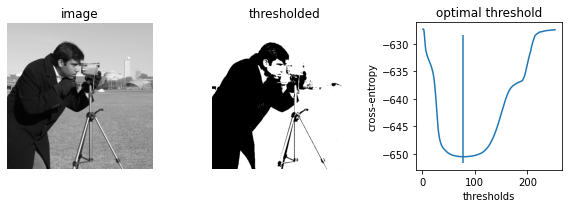

In [3]:
thresholds = np.arange(np.min(camera) + 1.5, np.max(camera) - 1.5)
entropies = [_cross_entropy(camera, t) for t in thresholds]

optimal_camera_threshold = thresholds[np.argmin(entropies)]

fig, ax = plt.subplots(1, 3, figsize=(8, 3))

ax[0].imshow(camera, cmap='gray')
ax[0].set_title('image')
ax[0].set_axis_off()

ax[1].imshow(camera > optimal_camera_threshold, cmap='gray')
ax[1].set_title('thresholded')
ax[1].set_axis_off()

ax[2].plot(thresholds, entropies)
ax[2].set_xlabel('thresholds')
ax[2].set_ylabel('cross-entropy')
ax[2].vlines(optimal_camera_threshold,
             ymin=np.min(entropies) - 0.05 * np.ptp(entropies),
             ymax=np.max(entropies) - 0.05 * np.ptp(entropies))
ax[2].set_title('optimal threshold')

fig.tight_layout()

print('The brute force optimal threshold is:', optimal_camera_threshold)
print('The computed optimal threshold is:', filters.threshold_li(camera))

plt.show()

Next, let's use the ``iter_callback`` feature of ``threshold_li`` to examine
the optimization process as it happens.



Only 5 thresholds examined.


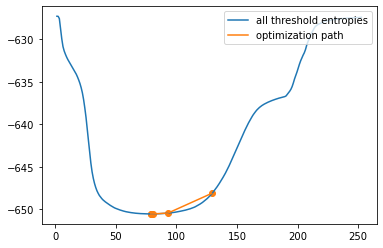

In [4]:
iter_thresholds = []

optimal_threshold = filters.threshold_li(camera,
                                         iter_callback=iter_thresholds.append)
iter_entropies = [_cross_entropy(camera, t) for t in iter_thresholds]

print('Only', len(iter_thresholds), 'thresholds examined.')

fig, ax = plt.subplots()

ax.plot(thresholds, entropies, label='all threshold entropies')
ax.plot(iter_thresholds, iter_entropies, label='optimization path')
ax.scatter(iter_thresholds, iter_entropies, c='C1')
ax.legend(loc='upper right')

plt.show()

This is clearly much more efficient than the brute force approach. However,
in some images, the cross-entropy is not *convex*, meaning having a single
optimum. In this case, gradient descent could yield a threshold that is not
optimal. In this example, we see how a bad initial guess for the optimization
results in a poor threshold selection.



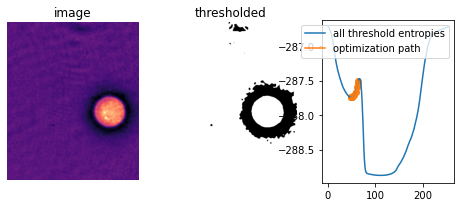

In [5]:
iter_thresholds2 = []

opt_threshold2 = filters.threshold_li(cell, initial_guess=64,
                                      iter_callback=iter_thresholds2.append)

thresholds2 = np.arange(np.min(cell) + 1.5, np.max(cell) - 1.5)
entropies2 = [_cross_entropy(cell, t) for t in thresholds]
iter_entropies2 = [_cross_entropy(cell, t) for t in iter_thresholds2]

fig, ax = plt.subplots(1, 3, figsize=(8, 3))

ax[0].imshow(cell, cmap='magma')
ax[0].set_title('image')
ax[0].set_axis_off()

ax[1].imshow(cell > opt_threshold2, cmap='gray')
ax[1].set_title('thresholded')
ax[1].set_axis_off()

ax[2].plot(thresholds2, entropies2, label='all threshold entropies')
ax[2].plot(iter_thresholds2, iter_entropies2, label='optimization path')
ax[2].scatter(iter_thresholds2, iter_entropies2, c='C1')
ax[2].legend(loc='upper right')

plt.show()

In this image, amazingly, the *default* initial guess, the mean image value,
actually lies *right* on top of the peak between the two "valleys" of the
objective function. Without supplying an initial guess, Li's thresholding
method does nothing at all!



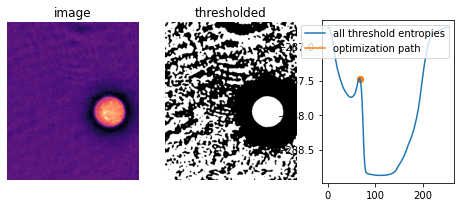

In [6]:
iter_thresholds3 = []

opt_threshold3 = filters.threshold_li(cell,
                                      iter_callback=iter_thresholds3.append)

iter_entropies3 = [_cross_entropy(cell, t) for t in iter_thresholds3]

fig, ax = plt.subplots(1, 3, figsize=(8, 3))

ax[0].imshow(cell, cmap='magma')
ax[0].set_title('image')
ax[0].set_axis_off()

ax[1].imshow(cell > opt_threshold3, cmap='gray')
ax[1].set_title('thresholded')
ax[1].set_axis_off()

ax[2].plot(thresholds2, entropies2, label='all threshold entropies')
ax[2].plot(iter_thresholds3, iter_entropies3, label='optimization path')
ax[2].scatter(iter_thresholds3, iter_entropies3, c='C1')
ax[2].legend(loc='upper right')

plt.show()

To see what is going on, let's define a function, ``li_gradient``, that
replicates the inner loop of the Li method and returns the *change* from the
current threshold value to the next one. When this gradient is 0, we are at
a so-called *stationary point* and Li returns this value. When it is
negative, the next threshold guess will be lower, and when it is positive,
the next guess will be higher.

In the plot below, we show the cross-entropy and the Li update path when the
initial guess is on the *right* side of that entropy peak. We overlay the
threshold update gradient, marking the 0 gradient line and the default
initial guess by ``threshold_li``.



8 examined, optimum: 111.68876119648344


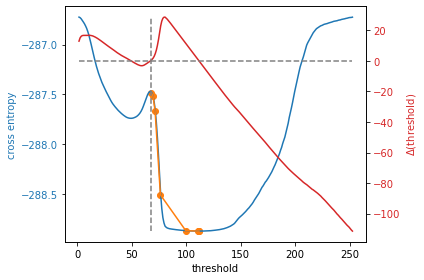

In [7]:
def li_gradient(image, t):
    """Find the threshold update at a given threshold."""
    foreground = image > t
    mean_fore = np.mean(image[foreground])
    mean_back = np.mean(image[~foreground])
    t_next = ((mean_back - mean_fore) /
              (np.log(mean_back) - np.log(mean_fore)))
    dt = t_next - t
    return dt


iter_thresholds4 = []
opt_threshold4 = filters.threshold_li(cell, initial_guess=68,
                                      iter_callback=iter_thresholds4.append)
iter_entropies4 = [_cross_entropy(cell, t) for t in iter_thresholds4]
print(len(iter_thresholds4), 'examined, optimum:', opt_threshold4)

gradients = [li_gradient(cell, t) for t in thresholds2]

fig, ax1 = plt.subplots()
ax1.plot(thresholds2, entropies2)
ax1.plot(iter_thresholds4, iter_entropies4)
ax1.scatter(iter_thresholds4, iter_entropies4, c='C1')
ax1.set_xlabel('threshold')
ax1.set_ylabel('cross entropy', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(thresholds2, gradients, c='C3')
ax2.hlines([0], xmin=thresholds2[0], xmax=thresholds2[-1],
           colors='gray', linestyles='dashed')
ax2.vlines(np.mean(cell), ymin=np.min(gradients), ymax=np.max(gradients),
           colors='gray', linestyles='dashed')
ax2.set_ylabel(r'$\Delta$(threshold)', color='C3')
ax2.tick_params(axis='y', labelcolor='C3')

fig.tight_layout()

plt.show()

In addition to allowing users to provide a number as an initial guess,
:func:`skimage.filters.threshold_li` can receive a function that makes a
guess from the image intensities, just like :func:`numpy.mean` does by
default. This might be a good option when many images with different ranges
need to be processed.



5 examined, optimum: 111.68876119648344


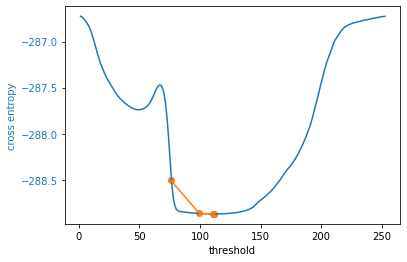

In [8]:
def quantile_95(image):
    # you can use np.quantile(image, 0.95) if you have NumPy>=1.15
    return np.percentile(image, 95)

iter_thresholds5 = []
opt_threshold5 = filters.threshold_li(cell, initial_guess=quantile_95,
                                      iter_callback=iter_thresholds5.append)
iter_entropies5 = [_cross_entropy(cell, t) for t in iter_thresholds5]
print(len(iter_thresholds5), 'examined, optimum:', opt_threshold5)

fig, ax1 = plt.subplots()
ax1.plot(thresholds2, entropies2)
ax1.plot(iter_thresholds5, iter_entropies5)
ax1.scatter(iter_thresholds5, iter_entropies5, c='C1')
ax1.set_xlabel('threshold')
ax1.set_ylabel('cross entropy', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

plt.show()